# Evaluation Metrics for Classification
Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [70]:
df = pd.read_csv('Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [71]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [72]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [73]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## 1. Accuracy and dummy model
- Evaluating the model on different thresholds
- Checking the accuracy of dummy baselines

In [74]:
# Checking which threshold value is suitable for our model 
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print("%.2f %.3f" % (t, score))
    scores.append(score)

# indeed in this case 0.5 gives most accurate answer

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [75]:
# We can find accuract with sklearn
from sklearn.metrics import accuracy_score

thresholds = np.linspace(0, 1, 21)

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f" % (t, score))


0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


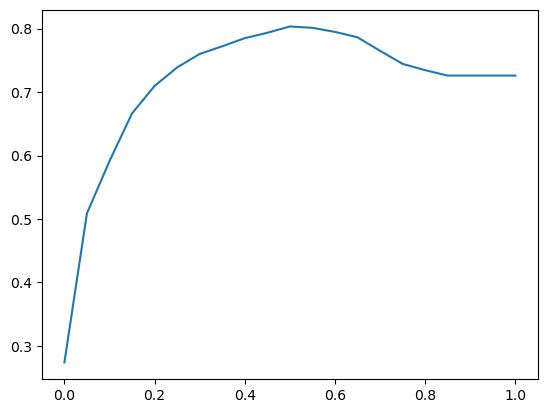

In [76]:
plt.plot(thresholds, scores)

In [77]:
from collections import Counter

Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [78]:

1 - y_val.mean()

np.float64(0.7260468417317246)

## 2. Confusion table
- Different types of errors and correct decisions
- Arranging them in a table

In [79]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [80]:
# t - True, f - False, p - Positive, n - Negative
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [81]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [82]:
# % of predictions in our model (65 + 15 is what out accuracy is (80%))
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 3. Precision and Recall

In [83]:
# We can find accuracy normally 
(tp + tn) / (tp + tn + fp + fn)

np.float64(0.8034066713981547)

In [84]:
# for precision (the correctness of our predictions)
p = tp / (tp + fp)
p

np.float64(0.6752411575562701)

In [85]:
# for recall (failed to identify )
r = tp / (tp + fn)
r

np.float64(0.5440414507772021)

## 4. ROC Curves

### TPR and FRP

In [86]:
# TPR and FPR stands for True/False positive rate 
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print(f"TPR is {tpr} and FPR is {fpr}")

TPR is 0.5440414507772021 and FPR is 0.09872922776148582


In [87]:
thresholds = np.linspace(0, 1, 101)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [88]:
columns = ["thresholds", "tp", "fp", "fn", "tn"] 
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,thresholds,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,75,20,311,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [89]:
df_scores["tpr"] =  df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores["fpr"] =  df_scores.fp / (df_scores.fp + df_scores.tn)

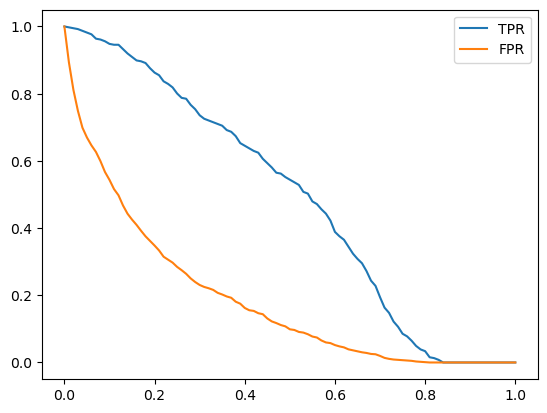

In [90]:
plt.plot(df_scores.thresholds, df_scores['tpr'], label = "TPR")
plt.plot(df_scores.thresholds, df_scores['fpr'], label = "FPR")
plt.legend()

### Random model

In [91]:
np.random.seed(1)

y_rand = np.random.uniform(0, 1, size = len(y_val))
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [92]:
def tpr_fpr_fn(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)
    scores = []
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))

    columns = ["thresholds", "tp", "fp", "fn", "tn"] 
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores["tpr"] =  df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores["fpr"] =  df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [93]:
df_rand = tpr_fpr_fn(y_val, y_rand)
df_rand[::10]

,thresholds,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


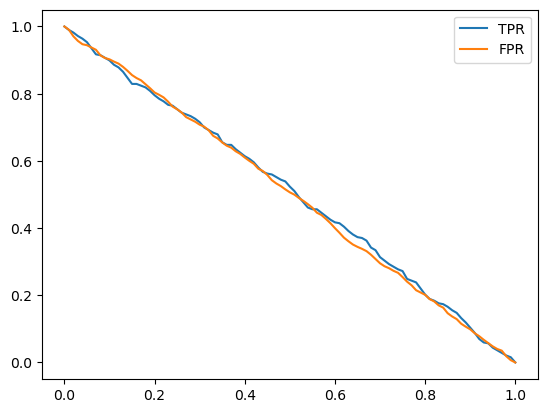

In [94]:
plt.plot(df_rand.thresholds, df_rand['tpr'], label = "TPR")
plt.plot(df_rand.thresholds, df_rand['fpr'], label = "FPR")
plt.legend()

### Ideal model

In [95]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(np.int64(1023), np.int64(386))

In [96]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [97]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [98]:
y_ideal_pred = np.linspace(0,1, len(y_val))
((y_ideal_pred >= 0.726 ) == y_ideal).mean()

np.float64(1.0)

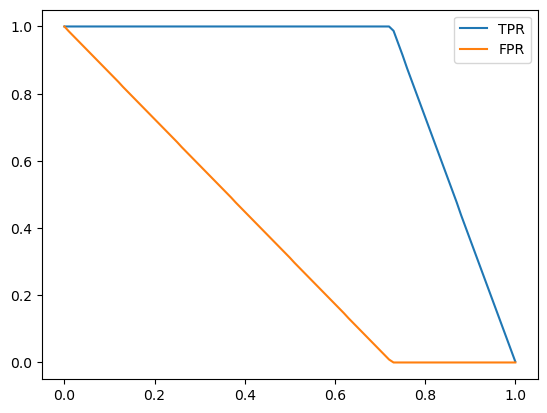

In [99]:
df_ideal = tpr_fpr_fn(y_ideal, y_ideal_pred)

plt.plot(df_ideal.thresholds, df_ideal['tpr'], label = "TPR")
plt.plot(df_ideal.thresholds, df_ideal['fpr'], label = "FPR")
plt.legend()

### Putting everythin together

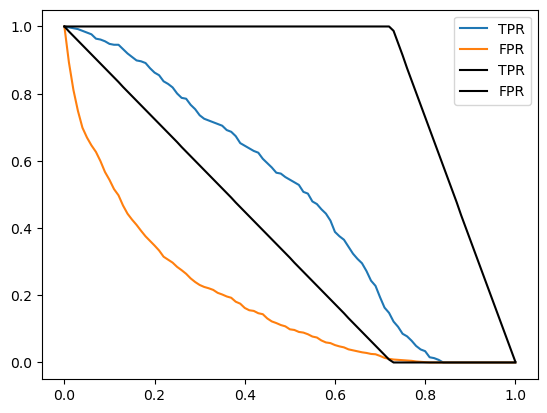

In [100]:
plt.plot(df_scores.thresholds, df_scores['tpr'], label = "TPR")
plt.plot(df_scores.thresholds, df_scores['fpr'], label = "FPR")

# plt.plot(df_rand.thresholds, df_rand['tpr'], label = "TPR")
# plt.plot(df_rand.thresholds, df_rand['fpr'], label = "FPR")

plt.plot(df_ideal.thresholds, df_ideal['tpr'], label = "TPR", color = 'black')
plt.plot(df_ideal.thresholds, df_ideal['fpr'], label = "FPR", color = 'black')
plt.legend()

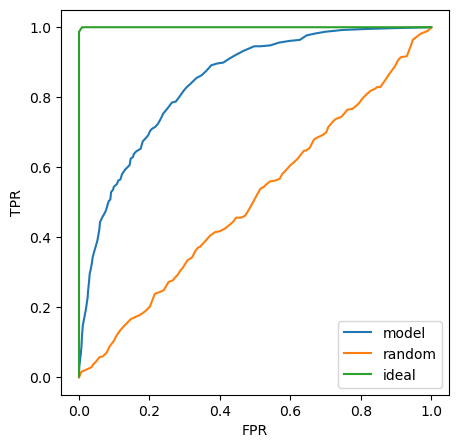

In [101]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label="model")
plt.plot(df_rand.fpr, df_rand.tpr, label="random")
plt.plot(df_ideal.fpr, df_ideal.tpr, label="ideal")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

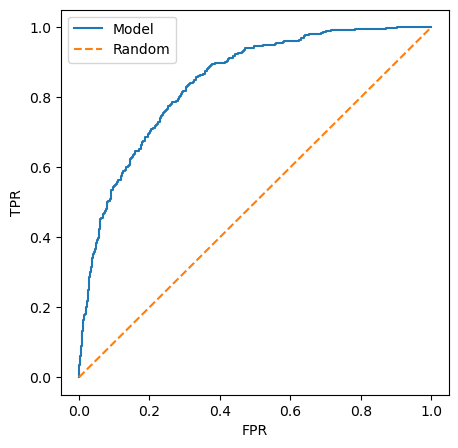

In [102]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label="Model")
plt.plot([0,1], [0,1], label="Random", linestyle = "--")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

## 5. ROC AUC 
- Area under the ROC curve - useful metric 
- Interpretation of AUC

In [103]:
# the greater the area the better the model 
from sklearn.metrics import auc
auc(fpr, tpr)

0.8438277138761845

In [104]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [105]:
# another easier way is 
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8438277138761845

In [106]:
# AUC - Prob. that randomly selected +ve has higher score than randomly selected -ve 
import random

neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

neg_ind = random.randint(0, len(neg) -1)
pos_ind = random.randint(0, len(pos) -1)

pos[pos_ind] > neg[neg_ind]

np.False_

In [107]:
# to check the %
n = 100000
success = 0 

for i in range(n):
    neg_ind = random.randint(0, len(neg) -1)
    pos_ind = random.randint(0, len(pos) -1)
    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.8418

In [108]:
# now via numpy

n = 100000

random.seed(1)
pos_ind = np.random.randint(0, len(pos), size = n)
neg_ind = np.random.randint(0, len(neg), size = n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84298)

## 6. K-fold Cross-Validation
- Evaluating the same model on different subsets of data
- Getting the avg. prediction and the spread within predictions 

In [132]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)

    return dv, model 


dv, model = train(df_train, y_train, C=0.001)

In [133]:
def predict(df_val, dv, model):
    dicts = df_val[categorical + numerical].to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

y_pred = predict(df_val, dv, model)

In [134]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
train_idx, val_idx = next(kfold.split(df_full_train))


In [135]:
from tqdm.auto import tqdm # to see the timing it takes 

In [141]:
n_splits = 5

for C in tqdm([0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        scores.append(roc_auc_score(y_val, y_pred))
    
    print("C=%s %.3f +-%.3f" % (C, np.mean(scores), np.std(scores)))


  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C=0.0001 0.811 +-0.009


0it [00:00, ?it/s]

C=0.001 0.825 +-0.009


0it [00:00, ?it/s]

C=0.01 0.840 +-0.008


0it [00:00, ?it/s]

C=0.1 0.842 +-0.007


0it [00:00, ?it/s]

C=1.0 0.842 +-0.007


0it [00:00, ?it/s]

C=5.0 0.842 +-0.007


0it [00:00, ?it/s]

C=10 0.842 +-0.007


In [142]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8584492508693814

## Summary 
- Metric - a single number that describes the performance of the model
- Accuracy - fraction of correct answers; sometimes misleading
- Precision and Recall are less misleading when we have class inbalance
- ROC Curve - a way to evaluate the performace at all thresholds; ok to use with imbalance
- K-fold CV - more reliable estimate for performance (mean + std)